In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks/np.rnn'

## Forward propagation formula

$x_j^{<t>}=\tau(\sum_is_iw_{ij}+b_j)+(1-\tau)x_j^{<t-\tau>}$

$s_j=\sigma(x_j)=\frac{1}{1+exp(-x_j)}$

---

$x_j^{<t>}$ is `input` : the input of unit $j$ at time step $t$

$\tau$ is `tau` : time stride (higher indicate faster "ramping up", typical RNN usually set $\tau =1$)

$s_i$ is `act` : the activation  (=state) of unit $i$

$w_{ij}$ is `w`: the weight from $i$ to $j$

$b_j$ is `bias`: the bias of unit $j$

$x_j^{<t-\tau>}$ is `input` : the input of unit $j$ at previous time step, i.e. memory

$\sigma$ is `af()` is the activation function (= binary logistic = sigmoid)



In [ ]:

from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras import Model

class rnnModel(Layer):
    from tensorflow.keras.activations import sigmoid
    def __init__(self):
        super(rnnModel, self).__init__()
        self.cleanup_dim = 50
        self.hidden_dim = 100
        self.ort_dim = 119
        self.pho_dim = 250

        self.nTimeSteps = 10
        self.tau = tf.constant([0.2], dtype=tf.float32)

        # initialize neural network weights
        self.w_oh = (tf.random.uniform([self.ort_dim, self.hidden_dim]) - 0.5) / 1000
        self.w_hp = (tf.random.uniform([self.hidden_dim, self.pho_dim]) - 0.5) / 1000
        self.w_pp = (tf.random.uniform([self.pho_dim, self.pho_dim]) - 0.5) / 1000
        # np.fill_diagonal(self.w_pp, 0) 
        self.w_cp = (tf.random.uniform([self.cleanup_dim, self.pho_dim]) - 0.5) / 1000
        self.w_pc = (tf.random.uniform([self.pho_dim, self.cleanup_dim]) - 0.5) / 1000

        # Forward propagation
        self.bias_h = (tf.random.uniform([1, self.hidden_dim]) - 0.5) / 1000
        self.bias_p = (tf.random.uniform([1, self.pho_dim]) - 0.5) / 1000
        self.bias_c = (tf.random.uniform([1, self.cleanup_dim]) - 0.5) / 1000

    def call(self, inputs):
        ### Trial level init ###
        self.input_h_list = []
        self.input_p_list = []
        self.input_c_list = []

        self.act_h_list =[]
        self.act_p_list =[]
        self.act_c_list =[]

        # Set input to 0
        self.input_h_list.append(tf.zeros((1, self.hidden_dim), dtype=tf.float32))
        self.input_p_list.append(tf.zeros((1, self.pho_dim), dtype=tf.float32))
        self.input_c_list.append(tf.zeros((1, self.cleanup_dim), dtype=tf.float32))

        # Set activations to 0.5
        self.act_h_list.append(self.input_h_list[0] + 0.5)
        self.act_p_list.append(self.input_p_list[0] + 0.5)
        self.act_c_list.append(self.input_c_list[0] + 0.5)

        for t in range(1, self.nTimeSteps):
            # print(f'Time step = {t}')
            ##### Hidden layer #####
            # Calculate temporary variables for readability
            oh = tf.matmul(inputs, self.w_oh) 
            mem_h = self.input_h_list[t-1]  

            h = self.tau*(oh + self.bias_h) + (1-self.tau)*mem_h

            # Write it to lists which store all input and activation in every time step
            self.input_h_list.append(h)
            self.act_h_list.append(sigmoid(h))

            # ##### Phonology layer #####
            hp = tf.matmul(self.act_h_list[t-1], self.w_hp)
            pp = tf.matmul(self.act_p_list[t-1], self.w_pp)
            cp = tf.matmul(self.act_c_list[t-1], self.w_cp)

            mem_p = self.input_p_list[t-1]
            p = self.tau*(hp + pp + cp + self.bias_p) + (1-self.tau)*mem_p

            self.input_p_list.append(p)
            self.act_p_list.append(sigmoid(p))

            ##### Cleanup layer #####
            pc = tf.matmul(self.act_p_list[t-1], self.w_pc)
            mem_c = self.input_c_list[t-1]
            c = self.tau*(pc + self.bias_c) + (1-self.tau)*mem_c

            self.input_c_list.append(c)
            self.act_c_list.append(sigmoid(c))
        return self.act_p_list[-1]


input_O = Input(shape=(119,))
rnnModel = rnnModel()(input_O)
model = Model(input_O, rnnModel)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['BinaryAccuracy', 'mse'])


tf.keras.utils.plot_model(model)

In [ ]:




x_train = np.load('x_train.npz')['data']
y_train = np.load('y_train.npz')['data']
### Input ###
input_o = x_train[trial,:]
input_o = tf.constant(input_o, dtype=tf.float32)
input_o = tf.expand_dims(input_o, axis=0)

### Y ###
y = y_train[trial,:]
y = tf.constant(y, dtype=tf.float32)
y = tf.expand_dims(y, axis=0)

# Collect the history of W-values and b-values to plot later
for epoch in epochs:


    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: loss=%2.5f' %(epoch, current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
[TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


# Loss function

In [ ]:
import pandas as pd
df_train = pd.read_csv('df_train.csv', index_col=0)

def sampleGenerator(x_set, y_set, batch_size, sample_p, rng_seed):
# Get <batch_size> of data from <x_set>, <y_set> based on the probability of <sample_p>
    np.random.seed(rng_seed)
    while 1:
        idx = np.random.choice(range(len(sample_p)), batch_size, p=sample_p)
        batch_x = x_set[idx]
        batch_y = y_set[idx]
        yield (batch_x, batch_y)


for batch in sampleGenerator(x_train, y_train, 300, df_train.p, rng_seed=1234):     
    adam.minimize(lambda: loss_function(x_train, w_oh, w_hp, w_pp, w_pc, w_cp, bias_h, bias_p, bias_c, y_train), 
                  var_list=[w_oh, w_hp, w_pp, w_pc, w_cp, bias_h, bias_p, bias_c])

In [ ]:
def saveTensorList(fileName, list_with_tensors):
    np.savetxt(fileName, np.squeeze(np.stack(list_with_tensors)), delimiter=',')

saveTensorList('tf_input_p.csv', input_p_list)

# Loss
def loss_function(predictions, ys):
    from tensorflow.keras.losses import binary_crossentropy
    return binary_crossentropy(ys, predictions)

# Vanilla gradient descent optimizer
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss_function(model(inputs), outputs)
        dw_oh, dw_hp, dw_pp, dw_pc, dw_cp, db_h, db_p, db_c = t.gradient(current_loss, [model.w_oh, model.w_hp, model.w_pp, model.w_pc, model.w_cp, model.bias_h, model.bias_p, model.bias_h])
        model.w_oh.assign_sub(learning_rate * dw_oh)
        model.w_hp.assign_sub(learning_rate * dw_hp)
        model.w_pp.assign_sub(learning_rate * dw_pp)
        model.w_pc.assign_sub(learning_rate * dw_pc)
        model.w_cp.assign_sub(learning_rate * dw_cp)

## Backward propagation formula
Binary crossentropy loss:

$C=-\sum_{i}t_ilog_2(s_i)+(1-t_i)log_2(1-s_i)$

$C$ is `lossf()`: Binary cross-entropy between pho output $s_i$ `yhat` and target $t_i$ `y`

---
Partial derivative of $C$ w.r.t. input $x_j$:

$\frac{\partial C}{\partial{x_j}}=\frac{\partial C}{\partial{s_j}}\frac{ds_j}{dx_j}$
$=(\frac{1-t_j}{1-s_j}-\frac{t_j}{s_j})s_j(1-s_j)=s_j-t_j$

---
BPTT with TAI:

Derivative of the error w.r.t input of unit $j$, i.e., define $\frac{\partial C}{\partial x_j} = \delta_j^{<t>}$

$\delta_j^{<t>}=\tau\frac{\partial C}{\partial s_j^{<t+\tau>}}\sigma^\prime (x_j^{<t+\tau>})+(1-\tau)\delta_j^{<t+\tau>}...(1)$

Consider

$\sigma(x_j) = s_j$

$\sigma^\prime(x_j) = \frac{ds_j}{dx_j} ...(2)$

Put (2) into (1), 

$\delta_j^{<t>}=\tau\frac{\partial C}{\partial s_j^{<t+\tau>}}\frac{ds_j^{<t+\tau>}}{dx_j^{<t+\tau>}}+(1-\tau)\delta_j^{<t+\tau>}...(3)$

Conside

$\frac{\partial C}{\partial{x_j}}=\frac{\partial C}{\partial{s_j}}\frac{ds_j}{dx_j}$
$=(\frac{1-t_j}{1-s_j}-\frac{t_j}{s_j})s_j(1-s_j)=s_j-t_j...(4)$ 

Put (4) into (3),

$\delta_j^{<t>}=\tau(s_j^{<t+\tau>} - t_j^{<t+\tau>})+(1-\tau)\delta_j^{<t+\tau>}...(5)$

According to Plaut96 there are two parts in this equation,
**a weighted average backwards in time of its current value and the contribution from the current error of the unit.**

Therefore, in (5) we should have:

- injected error (i.e., error from the discrepancy between its own state and target) scaled by $\tau$ at time $t$
- internal error (i.e., back prop error from other units) scaled by $1-\tau$ at time $t+\tau$

But, $s_j^{<t+\tau>} - t_j^{<t+\tau>}$ is the injected error of $t+\tau$ instead of $t$, which is a bit weird, because we already have the error form $t+\tau$ in $\delta_j^{<t+\tau>}$

### Issues to discuss
1. Did Plaut96 meant $s_j^{<t>} - t_j^{<t>}$ instead of $s_j^{<t+\tau>} - t_j^{<t+\tau>}$, therefore $\delta_j^{<t>}=\tau(s_j^{<t>} - t_j^{<t>})+(1-\tau)\delta_j^{<t+\tau>}$

2. Despite Plaut 96 said $\delta_j^{<t>}$ is **the derivative of the error with respect to the input of unit j**, i.e., applicable to all units. However, looking at the back prop direction, only layer P fits the description. 

### Generalize to our model with clean up

So, we need to generalize Plaut equation (no clean up) to fit our model with cleanup

$\delta_j^{<t>}=\tau(s_j^{<t>} - t_j^{<t>})+(1-\tau)(\delta_j^{<t+\tau>} + \sum_{k\neq j}\delta_k^{<t+\tau>})$

- injected error $s_j^{<t>} - t_j^{<t>}$ depends on model setting with these contrains
    - must from >= time step 2 (since no O_input info can reach there?)
    - must at Layer P (where it is the model level output)
    - (optional) Plaut 96 start injection from unit time >=2
- internal error $\delta_j^{<t+\tau>} + \sum_{k\neq j}\delta_k^{<t+\tau>}$ depends on model connection

### In Jay's ppt:
Internal error:

$\delta_j^{<t>}int = \tau(\sum_kw_{jk}\delta_k^{<t+\tau>})+(1-\tau)\delta_j^{<t+\tau>}$


Injected error:

$\delta_j^{<t>}inj = (t_j^{<t>}-a_j^{<t>})$

Total error:

$\delta_j^{<t>}total = \delta_j^{<t>}int + \delta_j^{<t>}inj$

### Discussion
- Discuss the rationale of internal error formulation




## Gradient of each trainable parameter

We have 4 sets of weights and 3 sets of biases. Before gradient descent (weight change) we need:
- $\frac{\partial C}{\partial w_{oh}}, \frac{\partial C}{\partial w_{hp}}, \frac{\partial C}{\partial w_{pp}}, \frac{\partial C}{\partial w_{cp}}$
- $\frac{\partial C}{\partial b_h}, \frac{\partial C}{\partial b_p}, \frac{\partial C}{\partial b_c}$

No details in Plaut96 paper
may need to apply chain rule manually... HELP!

- Option 1: Chain rule with symbolic diff (See Chen, 2018)
- Option 2: I can hand write auto diff... and cross check with tf auto diff 
- Option 3: Numeric diff... slowly


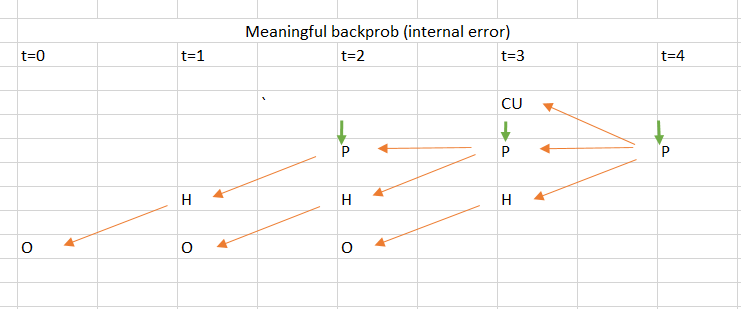

- Green arrow: injected error
- Orange arrow: back prop error (internal error)

Assume we only have 5 time steps, from 0 to 4 as illustrated by above figure.

First, we calculate $\frac{\partial C}{\partial bp^{<4>}}$

$= \frac{\partial C}{\partial x_j^{<4>}} \frac{\partial x_j^{<4>}}{\partial bp^{<4>}}$

$=(s_j^{<4>} - t_j^{<4>})(\frac{\partial {\tau(\sum_is_iw_{ip}+bp^{<4>})+(1-\tau)x_j^{<t-\tau>}}}{\partial bp^{<4>}})$

$=(s_j^{<4>} - t_j^{<4>})({\tau(1)})$

$=\tau(s_j^{<4>} - t_j^{<4>})$

Then we calculate $\frac{\partial C}{\partial bp^{<3>}}$

$= \frac{\partial C}{\partial x_j^{<4>}} \frac{\partial x_j^{<4>}}{\partial bp^{<4>}}$





## Gradient descent

---

Weight decay in cross-entropy during training:

$C_{decay} = C \times 0.0001 \times \sum_{i,j}w_{ij}^2$

Weight change:

$\Delta w_{ij}^{<t>} = \epsilon \epsilon_{ij}(\frac{\partial C_{decay}}{\partial w_{ij}}+\alpha \Delta w_{ij}^{<t-1>})$

$\Delta w_{ij}^{<t>}$ is `dw_ij`: change of weight from $i$ to $j$ at epoch $t$

**IMPORTANT**: $<t>$ is epoch t now, **NOT TIME!**

$\epsilon$ is `lr`: global learning rate

$\epsilon_{ij}$: specific learning rate of weight from $i$ to $j$ 

$\alpha$: if epoch >=10, momentum = 0.9, else momentum = 1.0

---

### Minimalistic version without weight decay, path specific learning rate, and momentum from last weight change

$\Delta w_{ij}^{<t>} = \epsilon\frac{\partial C}{\partial w_{ij}}$

### Jay's version
$\Delta w_{ij}^{<t>}=\lambda a_i^{<t-1>}\delta_j^{<t>}total$

## Jay's ppt

Internal error:

$\delta_j^{<t>}int = \tau(\sum_kw_{jk}\delta_k^{<t+\tau>})+
                     (1-\tau)\delta_j^{<t+\tau>}$


Injected error:

$\delta_j^{<t>}inj = (t_j^{<t>}-a_j^{<t>})$

Total error:

$\delta_j^{<t>}total = \delta_j^{<t>}int + \delta_j^{<t>}inj$

Weight change:

$\Delta w_{ij}^{<t>}=\lambda a_i^{<t-1>}\delta_j^{<t>}total$

# Hand check test code

In [ ]:
x_train = np.array([[1,0,1],[0,0,0]])
y_train = np.array([[0,1],[0,0]])

cleanup_dim = 2
hidden_dim = 3
ort_dim = x_train.shape[0]
pho_dim = y_train.shape[0]
nTimeSteps = 6 # We need at least 5 to test for whole cycle o-h-p-c-p
tau = 0.2 

# initialize neural network weights
w_oh = np.array([[0.1, 0.2, 0.3], [0.4, 0.2, 0.1], [0.7, 0.2, 0.1]])
w_hp = np.array([[0.4, 0.1], [0.2, 0.1], [0.6, 0.7]])
w_pp = np.array([[0.3, 0.2], [0.6, 0.1]])
np.fill_diagonal(w_pp, 0)  # Set diagonal of w_pp = 0    <-- discuss... the formula did not indicate i =/= j
w_cp = np.array([[0.1, 0.3], [0.3, 0.2]])
w_pc = np.array([[0.2, 0.0], [0.1, 0.3]])

# Forward propagation
bias_h = np.zeros(hidden_dim)
bias_p = np.zeros(pho_dim)
bias_c = np.zeros(cleanup_dim)

In [ ]:
# print('=================== Model params shape ===================')
# print(f'input_o shape: {input_o.shape}')
# print(f'w_oh: {w_oh.shape}')
# print(f'w_hp: {w_hp.shape}')
# print(f'w_pc: {w_pc.shape}')
# print(f'w_pp: {w_pp.shape}')
# print(f'w_cp: {w_cp.shape}')
# print(f'bias_h: {bias_h.shape}')
# print(f'bias_p: {bias_p.shape}')
# print(f'bias_c: {bias_c.shape}')
# print(f'y shape: {y.shape}')

# print('=================== Recurrent units shape ===================')
# print(f'input_h shape: {input_h_list[0].shape}')
# print(f'input_p shape: {input_p_list[0].shape}')
# print(f'input_c shape: {input_c_list[0].shape}')
# print(f'act_h shape: {act_h_list[0].shape}')
# print(f'act_p shape: {act_p_list[0].shape}')
# print(f'act_c shape: {act_c_list[0].shape}')